# Configuration 

In [1]:
import sys 
import easydict
sys.path.append('../')
from utils.data import name_to_class
args = easydict.EasyDict(
    {
        'model_path': '../artifacts/pmg_uni/exp1',
        'arch': 'pmg', # 'pmg', 'resnet'
        'method': 'uni', # 'uni', 'multi', 'baseline'
        
        'data_root_path': '../../../../dataset/99_ext_car_dirt_defect_multi',

        'train_class': 'outer_normal,outer_damage,outer_dirt,outer_wash,inner_wash,inner_dashboard,inner_cupholder,inner_glovebox,inner_washer_fluid,inner_rear_seat,inner_sheet_dirt', 
        'test_class': 'outer_normal,outer_damage,outer_dirt,outer_wash,inner_wash,inner_dashboard,inner_cupholder,inner_glovebox,inner_washer_fluid,inner_rear_seat,inner_sheet_dirt', 

        'num_workers': 4, 
        'batch_size': 128 ,
        'ce_label': False, 
        'show_img': False, # to show result imgs 
    }
)
args.train_class_name = [item for item in args.train_class.split(',')]
args.test_class_name = [item for item in args.test_class.split(',')]

args.train_class = [name_to_class[item] for item in args.train_class.split(',')]
args.test_class = [name_to_class[item] for item in args.test_class.split(',')]

# Dataloader 

In [2]:
import cv2
import glob 
from PIL import Image, ImageFile

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

ImageFile.LOAD_TRUNCATED_IMAGES = True

normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

test_transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            normalize
        ])

class SofarExtDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.data = glob.glob(root + '/*.jpg')
        
        self.transform = transform
        
    def __getitem__(self, index):
        path  = self.data[index]
        filename = path.split('/')[-1]
        # x = Image.open(path).convert("RGB")
        img = cv2.imread(path)[:,:,::-1]
        x = Image.fromarray(img)
        
        if self.transform is not None:
            x = self.transform(x)
        return x, path

    def __len__(self):
        return len(self.data)

In [3]:
# external validation dataloader 
ext_dataset = SofarExtDataset(args.data_root_path, 
                                transform=test_transform)
print(len(ext_dataset))
ext_loader = DataLoader(
            ext_dataset,
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=args.num_workers,
            pin_memory=True,
            drop_last=False,
        ) 

38


# Model

In [4]:
import os 
import torch 
import torch.nn as nn 

from model.set_model import set_model

model = set_model(args)

state_dict = torch.load(os.path.join(args.model_path, 'last.pth'), map_location='cpu')
model.load_state_dict(state_dict)
print('pre-trained v2 model is loaded')

pre-trained v2 model is loaded


# Test

In [5]:
from tqdm import tqdm 
import numpy as np 

@torch.no_grad() 
def test(dataloader, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    model.eval()

    top1, top2 = [], []

    for (img, path) in tqdm(dataloader):
        img = img.to(device)

        # forward
        if args.arch == 'resnet':
            out = model(img)
            
        elif args.arch == 'pmg':
            out = model._forward(img)
            out = out[-1]
        
        # pred 
        if args.method == 'uni':
            # _, pred = torch.max(out, 1)
            _, pred = torch.topk(out, dim=1, k=2) 
            top1.extend(pred[:,0].view(-1).cpu().detach().numpy().tolist())
            top2.extend(pred[:,1].view(-1).cpu().detach().numpy().tolist())
    
    return top1, top2

In [6]:
top1, top2 = test(ext_loader, model)

100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


In [7]:
def get_result(top_pred):
    num_data = len(top_pred) 

    class_to_name = {1:'outer_damage', 2:'outer_dirt'}

    counts = {}
    for k in class_to_name:
        count = 0 
        for v in top_pred:
            if v == k:
                count += 1 
        counts[class_to_name[k]] = float(count) / num_data 

    counts['etc'] = 1- sum(counts.values())

    return counts 

{'outer_damage': 0.8421052631578947, 'outer_dirt': 0.13157894736842105, 'etc': 0.026315789473684292}
{'outer_damage': 0.13157894736842105, 'outer_dirt': 0.6578947368421053, 'etc': 0.21052631578947367}


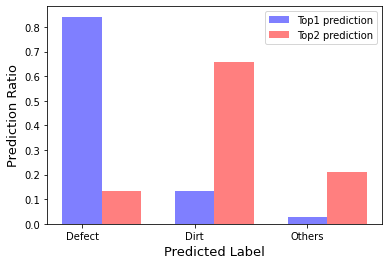

In [8]:
import matplotlib.pyplot as plt

top1_result = get_result(top1)
top2_result = get_result(top2)

print(top1_result)
print(top2_result)

bar_width = 0.35
alpha = 0.5

index = np.arange(len(top1_result.keys()))
p1 = plt.bar(index, top1_result.values(),
            bar_width, 
            color='b', 
            alpha=alpha,
            label='Top1 prediction')
p2 = plt.bar(index+ bar_width, top2_result.values(),
            bar_width, 
            color='r', 
            alpha=alpha,
            label='Top2 prediction')
plt.ylabel('Prediction Ratio', fontsize=13)

plt.xlabel('Predicted Label', fontsize=13)

# plt.xticks(index, top1_result.keys())
plt.xticks(index, ['Defect', 'Dirt', 'Others'])

plt.legend()
plt.show()
